In [1]:
# Imports
import sys, os
import zipfile
import numpy as np
import h5py
import torch
import re
import matplotlib.pyplot as plt
import math

from SlayerSNN_src.auto.loihi import denseBlock, convBlock, flattenBlock, poolBlock, Network
from SlayerSNN_src.slayerLoihi import spikeLayer as loihi
from SlayerSNN_src import utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import HTML

from SlayerSNN_src.slayer import spikeLayer as layer
from SlayerSNN_src.slayerLoihi import spikeLayer as loihi
from SlayerSNN_src.slayerParams import yamlParams as params
from SlayerSNN_src.spikeLoss import spikeLoss as loss
from SlayerSNN_src.spikeClassifier import spikeClassifier as predict
from SlayerSNN_src import spikeFileIO as io
from SlayerSNN_src import utils
# This will be removed later. Kept for compatibility only
from SlayerSNN_src.quantizeParams import quantizeWeights as quantize

# Added for debug
%matplotlib inline

In [2]:
# Threshold
threshold = 10 # 1, 2, 5, 10
run = "_3"

if threshold == 1:
    time_bin_size = 5
    nb_input_copies = 2
    tau_mem = 0.06
    tau_ratio = 10
elif threshold == 2:
    time_bin_size = 3
    nb_input_copies = 8
    tau_mem = 0.05
    tau_ratio = 10
elif threshold == 5:
    time_bin_size = 3
    nb_input_copies = 4
    tau_mem = 0.07
    tau_ratio = 10
elif threshold == 10:
    time_bin_size = 5
    nb_input_copies = 2
    tau_mem = 0.07
    tau_ratio = 10

# SpyTorch weights
weights_path = "../weights/SpyTorch_trained_weights_fwd_th" + str(threshold) + run + ".pt"

In [3]:
# Import weights
path = weights_path
SpyTorch_weights = torch.load(path, map_location=torch.device('cpu'))

wgt1_in2hid = SpyTorch_weights[0].detach().numpy()
wgt2_hid2out = SpyTorch_weights[1].detach().numpy()

In [4]:
print(np.shape(SpyTorch_weights[1].detach().numpy()))
print(SpyTorch_weights[1].detach().numpy())

(450, 28)
[[ 0.09514701 -0.2498929  -0.21983077 ... -0.42935914  0.093075
  -0.22871235]
 [-0.37213632 -0.02317753 -0.06820287 ... -0.22371764 -0.07909746
  -0.14899771]
 [ 0.01635543 -0.2587211  -0.03930256 ...  0.2052648   0.14091352
  -0.5218253 ]
 ...
 [ 0.21863535  0.16354123  0.47647065 ...  0.12791806  0.12644301
  -0.8379483 ]
 [-0.02220986 -0.42480463 -0.06455369 ... -0.16587071  0.43334395
   0.15958126]
 [ 0.21037246  0.02932504 -0.16226019 ... -0.10203745  0.04537127
  -0.2431798 ]]


In [5]:
print(np.shape(SpyTorch_weights[0].detach().numpy()))

(48, 450)


In [6]:
# Loihi inference parameters approximation
wgt_max = np.amax([np.amax(np.abs(wgt1_in2hid)), 
                   np.amax(np.abs(wgt2_hid2out))])
wgt_scale_calc = math.floor(256/wgt_max) # round down
tau_syn = tau_mem/tau_ratio
alpha = float(np.exp(-(time_bin_size/1000)/tau_syn))
beta = float(np.exp(-(time_bin_size/1000)/tau_mem))
vDecay_calc = int(4096-4096*beta)
iDecay_calc = int(4096-4096*alpha)
time_bins = math.ceil(1350/time_bin_size) # round up

print("wgt_scale_calc = ", wgt_scale_calc)
print("vDecay_calc = ", vDecay_calc)
print("iDecay_calc = ", iDecay_calc)
print("time_bins = ", time_bins)

wgt_scale_calc =  99
vDecay_calc =  282
iDecay_calc =  2090
time_bins =  270


In [7]:
# Loihi inference parameters
wgt_scale = wgt_scale_calc # scale for all weight
vThMant = wgt_scale_calc # vth = vthMant ∗ 64
vDecay = vDecay_calc # tau_mem
iDecay = iDecay_calc # tau_syn

qtz_step = 2 # weights quantization step
rec_scale = 1 # extra scale for recurrent weights
refDelay = 1 # refractory delay
wgtExp = 0 # 2**(6+wgtExp) * W * spike_input

(array([   7.,   68.,  473., 2047., 4895., 6715., 5019., 1914.,  408.,
          54.]),
 array([-255.82756 , -209.13321 , -162.43886 , -115.7445  ,  -69.05015 ,
         -22.355797,   24.338556,   71.032906,  117.727264,  164.42162 ,
         211.11597 ], dtype=float32),
 <BarContainer object of 10 artists>)

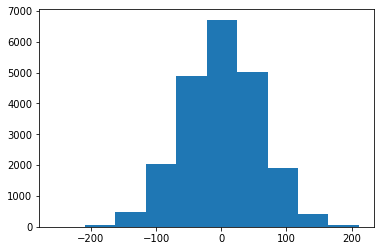

In [8]:
plt.hist(SpyTorch_weights[0].detach().numpy().flatten() * wgt_scale)

In [9]:
# Reshape weights
spy_weights = []

spy_weights.append([]) # flatten layer

spy_weights.append(np.reshape(
                        np.transpose(
                            SpyTorch_weights[0].detach().numpy()
                        ), 
                        (450, 24*nb_input_copies, 1, 1, 1)) * wgt_scale)

spy_weights.append(np.reshape(
                        np.transpose(
                            SpyTorch_weights[1].detach().numpy()
                        ),
                        (28, 450, 1, 1, 1)) * wgt_scale)

In [10]:
# Describe the network
netDesc = {
    'simulation' : {
        'Ts': 1,
        'tSample': time_bins,
    },
    'neuron' : {
        'type'     : 'LOIHI',
        'vThMant'  : vThMant,
        'vDecay'   : vDecay,
        'iDecay'   : iDecay,
        'refDelay' : refDelay,
        'wgtExp'   : wgtExp,
        'tauRho'   : 1, # useless in inference
        'scaleRho' : 1, # useless in inference
    },
    'layer' : [
        {'dim' : "'" + str(24*nb_input_copies) + "x1x1"}, # Width x Height x Channels
        {'dim' : 450, 'delay' : False},
        {'dim' : 28, 'delay' : False}
    ]
}

netParams = params(dict=netDesc)

In [11]:
class recurrentBlock(torch.nn.Module):
    def __init__(self, slayer, inFeatures, outFeatures, weightScale, 
                 preHookFx = lambda x: utils.quantize(x, step=qtz_step), weightNorm=False, 
                 delay=False, maxDelay=62, countLog=False):
        super(recurrentBlock, self).__init__()
        self.slayer = slayer
        self.weightNorm = weightNorm
        if weightNorm is True:
            self.weightOp = torch.nn.utils.weight_norm(slayer.dense(
                inFeatures, outFeatures, weightScale, preHookFx), name='weight')
            self.recWeightOp = torch.nn.utils.weight_norm(slayer.dense(
                outFeatures, outFeatures, weightScale, preHookFx), name='recWeight')
        else:
            self.weightOp = slayer.dense(inFeatures, outFeatures, weightScale, preHookFx)
            self.recWeightOp = slayer.dense(outFeatures, outFeatures, weightScale, preHookFx)
        self.delayOp  = slayer.delay(outFeatures) if delay is True else None
        self.countLog = countLog
        self.gradLog = True
        self.maxDelay = maxDelay
        
        self.paramsDict = {
            'inFeatures'  : inFeatures,
            'outFeatures' : outFeatures,
        }
    
    def forward(self, spike):
        spike = self.slayer.spikeLoihi(self.weightOp(spike) + self.recWeightOp(spike))
        spike = self.slayer.delayShift(spike, 1)
        if self.delayOp is not None:
            spike = self.delayOp(spike)
        if self.countLog is True:
            return spike, torch.sum(spike)
        else:
            return spike

In [12]:
class SpyTorch2Loihi(Network):
    
    def __init__(self, netParams, weights):
        super(SpyTorch2Loihi, self).__init__(netParams)
        self.preHookFx = lambda x: utils.quantize(x, step=qtz_step)
        
        # Load the weights trained in spytorch
        self.weights = weights
        self.recWeights = None
    
    
    def _layerType(self, dim):
        if type(dim) is int:
            return 'dense'
        elif dim.find('c') != -1:
            return 'conv'
        elif dim.find('avg') != -1:
            return 'average'
        elif dim.find('a') != -1:
            return 'pool'
        elif dim.find('x') != -1:
            return 'input'
        elif dim.find('r') != -1:
            return 'recurrent'
        else:
            raise Exception('Could not parse the layer description. Found {}'.format(dim))
        # return [int(i) for i in re.findall(r'\d+', dim)]

    
    def _parseLayers(self):
        i = 0
        blocks = torch.nn.ModuleList()
        layerDim = [] # CHW
        is1Dconv = False

        print('\nNetwork Architecture:')
        # print('=====================')
        print(self._tableStr(header=True))

        for layer in self.netParams['layer']:
            layerType = self._layerType(layer['dim'])
            # print(i, layerType)

            # If layer has neuron feild, then use the slayer initialized with it and self.netParams['simulation']
            if 'neuron' in layer.keys():
                print(layerType, 'using individual slayer')
                slayer = loihi(layer['neuron'], self.netParams['simulation'])
            else:
                slayer = self.slayer

            if i==0 and self.inputShape is None: 
                if layerType == 'input':
                    self.inputShape = tuple([int(numStr) for numStr in re.findall(r'\d+', layer['dim'])])
                    if len(self.inputShape) == 3:
                        layerDim = list(self.inputShape)[::-1]
                    elif len(self.inputShape) == 2:
                        layerDim = [1, self.inputShape[1], self.inputShape[0]]
                    else:
                        raise Exception('Could not parse the input dimension. Got {}'.format(self.inputShape))
                elif layerType == 'dense':
                    self.inputShape = tuple([layer['dim']])
                    layerDim = [layer['dim'], 1, 1]
                else:
                    raise Exception('Input dimension could not be determined! It should be the first entry in the' 
                                    + "'layer' feild.")
                # print(self.inputShape)
                print(self._tableStr('Input', layerDim[2], layerDim[1], layerDim[0]))
                if layerDim[1] == 1:
                    is1Dconv = True
            else:
                # print(i, layer['dim'], self._layerType(layer['dim']))
                if layerType == 'conv':
                    params = [int(i) for i in re.findall(r'\d+', layer['dim'])]
                    inChannels  = layerDim[0]
                    outChannels = params[0]
                    kernelSize  = params[1]
                    stride      = layer['stride']   if 'stride'   in layer.keys() else 1
                    padding     = layer['padding']  if 'padding'  in layer.keys() else kernelSize//2
                    dilation    = layer['dilation'] if 'dilation' in layer.keys() else 1
                    groups      = layer['groups']   if 'groups'   in layer.keys() else 1
                    weightScale = layer['wScale']   if 'wScale'   in layer.keys() else 100
                    delay       = layer['delay']    if 'delay'    in layer.keys() else False
                    maxDelay    = layer['maxDelay'] if 'maxDelay' in layer.keys() else 62
                    # print(i, inChannels, outChannels, kernelSize, stride, padding, dilation, groups, weightScale)
                    
                    if is1Dconv is False:
                        blocks.append(convBlock(slayer, inChannels, outChannels, kernelSize, stride, padding, 
                                                dilation, groups, weightScale, self.preHookFx, self.weightNorm, 
                                                delay, maxDelay, self.countLog))
                        layerDim[0] = outChannels
                        layerDim[1] = int(np.floor((layerDim[1] + 2*padding - dilation * (kernelSize - 1) - 1)/stride + 1))
                        layerDim[2] = int(np.floor((layerDim[2] + 2*padding - dilation * (kernelSize - 1) - 1)/stride + 1))
                    else:
                        blocks.append(convBlock(slayer, inChannels, outChannels, [1, kernelSize], [1, stride], [0, padding], 
                                                [1, dilation], groups, weightScale, self.preHookFx, self.weightNorm, 
                                                delay, maxDelay, self.countLog))
                        layerDim[0] = outChannels
                        layerDim[1] = 1
                        layerDim[2] = int(np.floor((layerDim[2] + 2*padding - dilation * (kernelSize - 1) - 1)/stride + 1))
                    self.layerDims.append(layerDim.copy())

                    print(self._tableStr('Conv', layerDim[2], layerDim[1], layerDim[0], kernelSize, stride, padding, 
                          delay, sum(p.numel() for p in blocks[-1].parameters() if p.requires_grad)))
                elif layerType == 'pool':
                    params = [int(i) for i in re.findall(r'\d+', layer['dim'])]
                    # print(params[0])
                    
                    blocks.append(poolBlock(slayer, params[0], countLog=self.countLog))
                    layerDim[1] = int(np.ceil(layerDim[1] / params[0]))
                    layerDim[2] = int(np.ceil(layerDim[2] / params[0]))
                    self.layerDims.append(layerDim.copy())

                    print(self._tableStr('Pool', layerDim[2], layerDim[1], layerDim[0], params[0]))
                elif layerType == 'dense':
                    params = layer['dim']
                    # print(params)
                    if layerDim[1] != 1 or layerDim[2] != 1: # needs flattening of layers
                        blocks.append(flattenBlock(self.countLog ))
                        layerDim[0] = layerDim[0] * layerDim[1] * layerDim[2]
                        layerDim[1] = layerDim[2] = 1
                        self.layerDims.append(layerDim.copy())
                    weightScale = layer['wScale']   if 'wScale'   in layer.keys() else 100
                    delay       = layer['delay']    if 'delay'    in layer.keys() else False
                    maxDelay    = layer['maxDelay'] if 'maxDelay' in layer.keys() else 62
                    
                    blocks.append(denseBlock(slayer, layerDim[0], params, weightScale, self.preHookFx, 
                                  self.weightNorm, delay, maxDelay, self.countLog))
                    layerDim[0] = params
                    layerDim[1] = layerDim[2] = 1
                    self.layerDims.append(layerDim.copy())

                    print(self._tableStr('Dense', layerDim[2], layerDim[1], layerDim[0], delay=delay, 
                                        numParams=sum(p.numel() for p in blocks[-1].parameters() if p.requires_grad)))
                elif layerType == 'recurrent':
                    #params = layer['dim']
                    params = [int(i) for i in re.findall(r'\d+', layer['dim'])]
                    # print(params)
                    if layerDim[1] != 1 or layerDim[2] != 1: # needs flattening of layers
                        blocks.append(flattenBlock(self.countLog ))
                        layerDim[0] = layerDim[0] * layerDim[1] * layerDim[2]
                        layerDim[1] = layerDim[2] = 1
                        self.layerDims.append(layerDim.copy())
                    weightScale = layer['wScale']   if 'wScale'   in layer.keys() else 100
                    delay       = layer['delay']    if 'delay'    in layer.keys() else False
                    maxDelay    = layer['maxDelay'] if 'maxDelay' in layer.keys() else 62
                    
                    blocks.append(recurrentBlock(slayer, layerDim[0], params[0], weightScale, self.preHookFx, 
                                  self.weightNorm, delay, maxDelay, self.countLog))
                    layerDim[0] = params[0]
                    layerDim[1] = layerDim[2] = 1
                    self.layerDims.append(layerDim.copy())

                    print(self._tableStr('Recurrent', layerDim[2], layerDim[1], layerDim[0], delay=delay, 
                                        numParams=sum(p.numel() for p in blocks[-1].parameters() if p.requires_grad)))
                elif layerType == 'average':
                    params = [int(i) for i in re.findall(r'\d+', layer['dim'])]
                    layerDim[0] = params[0]
                    layerDim[1] = layerDim[2] = 1
                    self.layerDims.append(layerDim.copy())

                    blocks.append(averageBlock(nOutputs=layerDim[0], countLog=self.countLog))
                    print(self._tableStr('Average', 1, 1, params[0]))

                i += 1
        self.nOutput = layerDim[0] * layerDim[1] * layerDim[2]
        print(self._tableStr(numParams=sum(p.numel() for p in blocks.parameters() if p.requires_grad), footer=True))
        return blocks
    
    
    def genSpyModel(self, fname):
        qWeights = lambda x: self.preHookFx(x).cpu().data.numpy().squeeze()

        h = h5py.File(fname, 'w')

        simulation = h.create_group('simulation')

        for key, value in self.netParams['simulation'].items():
            # print(key, value)
            simulation[key] = value

        layer = h.create_group('layer')
        layer.create_dataset('0/type', (1, ), 'S10', [b'input'])
        layer.create_dataset('0/shape', data=np.array([self.inputShape[2], self.inputShape[1], self.inputShape[0]]))
        
        for i, block in enumerate(self.blocks):
            print("\nblock %d / %d" % (i, len(self.blocks)))
            layerType = block.__class__.__name__[:-5]
            
            print(layerType.encode('ascii', 'ignore'))
            layer.create_dataset('{}/type'.format(i+1), (1, ), 'S10', [layerType.encode('ascii', 'ignore')])
            
            print(i, self.layerDims[i])
            layer.create_dataset('{}/shape'.format(i+1), data=np.array(self.layerDims[i]))
            
            if layerType != 'flatten':
                layer.create_dataset('{}/weight'.format(i+1), data=qWeights(torch.Tensor(self.weights[i])))
                if layerType == 'recurrent':
                    layer.create_dataset('{}/recWeight'.format(i+1), data=qWeights(torch.Tensor(self.recWeights)))
                    
            for key, param in block.paramsDict.items():
                layer.create_dataset('{}/{}'.format(i+1, key), data=param)
                
            if layerType != 'flatten' and layerType != 'average':
                for key, value in block.slayer.neuron.items():
                    # print(i, key, value)
                    layer.create_dataset('{}/neuron/{}'.format(i+1, key), data=value)
        h.close()

In [13]:
# Create the network
netLoihi = SpyTorch2Loihi(netParams, spy_weights)

simulation:
    Ts         : 1
    tSample    : 270

neuron:
    type       : LOIHI
    vThMant    : 99
    vDecay     : 282
    iDecay     : 2090
    refDelay   : 1
    wgtExp     : 0
    tauRho     : 1
    scaleRho   : 1

Max PSP kernel: 99.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi

Network Architecture:
|   Type   |  W  |  H  |  C  | ker | str | pad |delay|  params  |
|Input     |   48|    1|    1|     |     |     |False|          |
|Dense     |    1|    1|  450|     |     |     |False|     21600|
|Dense     |    1|    1|   28|     |     |     |False|     12600|
|Total                                               |     34200|
TODO core usage estimator


In [14]:
# Export the model
netLoihi.genSpyModel('../netsLoihi/netLoihi_fwd_th' + str(threshold) + run + '.net')


block 0 / 3
b'flatten'
0 [48, 1, 1]

block 1 / 3
b'dense'
1 [450, 1, 1]

block 2 / 3
b'dense'
2 [28, 1, 1]
